Reading classics [Deep Learning Models](https://nbviewer.jupyter.org/github/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/nin-cifar10.ipynb)

## Code Modules, Classes, & Functions

[GoogleColaboratory Variant](https://colab.research.google.com/drive/1V9fDIPwPPi0gMkyDxOcMEu7-VHI1CjTm)

In [1]:
import numpy as np,pandas as pd,pylab as pl
import h5py,torch
from torchvision.datasets import CIFAR10 as tcifar10
from torchvision import transforms,utils
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
import torch.nn.functional as tnnf
import torch.nn as tnn
from torch.utils.data.dataset import Subset
import tensorflow.image as timage
import sklearn.preprocessing as skp
from IPython.core.magic import register_line_magic
dev=torch.device("cuda:0" \
if torch.cuda.is_available() else "cpu")

In [2]:
class TData(tds):
    def __init__(self,x,y):   
        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        img,lbl=self.x[index],self.y[index]
        return img,lbl
    def __len__(self):
        return self.y.shape[0]

In [3]:
def display_examples(data_loader,img_size):
    for images,labels in data_loader:  
        print('Image dimensions: %s'%str(images.shape))
        print('Label dimensions: %s'%str(labels.shape))
        n=np.random.randint(1,50)
        fig=pl.figure(figsize=(11,4))
        for i in range(n,n+5):
            ax=fig.add_subplot(1,5,i-n+1,\
            xticks=[],yticks=[],title=labels[i].item())
            ax.imshow((images[i])\
                      .reshape(img_size,img_size,3))
        break
def show_image(img):
    npimg=img.numpy()/2.+.5; tr=(1,2,0)
    pl.figure(figsize=(10,2))
    pl.imshow(np.transpose(npimg,tr))
    pl.xticks([]); pl.show()
def show_examples(train_loader,classes,num_examples):
    dataiter=iter(train_loader)
    images,labels=dataiter.next()
    show_image(utils.make_grid(images[0:num_examples]))
    print('^'.join('%9s'%classes[labels[j]] 
                   for j in range(num_examples)),end='^')

In [4]:
def model_acc(model,data_loader):
    correct_preds,num_examples=0,0    
    for features,targets in data_loader:
        features=features.to(dev)
        targets=targets.to(dev)
        logits,probs=model(features)
        _,pred_labels=torch.max(probs,1)
        num_examples+=targets.size(0)
        correct_preds+=(pred_labels==targets).sum()        
    return correct_preds.float()/num_examples*100
@register_line_magic
def print_acc(n):
    if int(n)==1:
        data_loader=\
        [train_loader,valid_loader,test_loader]
    if int(n)==2:
        data_loader=\
        [train_loader2,valid_loader2,test_loader2]
    print('Train accuracy: %.4f%%'%\
    (model_acc(model,data_loader[0])))
    print('Valid accuracy: %.4f%%'%\
    (model_acc(model,data_loader[1])))
    print('Test accuracy: %.4f%%'%\
    (model_acc(model,data_loader[2])))

## Data

In [5]:
img_size=32
random_seed=1; batch_size=128
train_ids=torch.arange(0,44000)
valid_ids=torch.arange(44000,50000)
tr0=(.5,.5,.5); tr1=(.48,.48,.48)
train_transform=transforms\
.Compose([transforms.ToTensor(),
          transforms.Normalize(tr0,tr0)])
test_transform=transforms\
.Compose([transforms.ToTensor(),
          transforms.Normalize(tr0,tr0)])
train_valid=tcifar10(root='data',train=True,
                     download=True,
                     transform=train_transform)
train=Subset(train_valid,train_ids)
valid=Subset(train_valid,valid_ids)
test=tcifar10(root='data',train=False, 
              transform=test_transform)
train_loader=tdl(dataset=train,shuffle=True, 
                 batch_size=batch_size)
valid_loader=tdl(dataset=valid,shuffle=True, 
                 batch_size=batch_size)
test_loader=tdl(dataset=test,shuffle=False, 
                batch_size=batch_size)

Extracting data/cifar-10-python.tar.gz to data


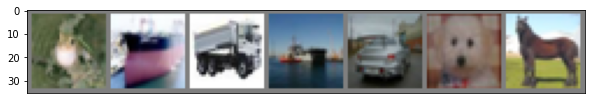

     frog^     ship^    truck^     ship^      car^      dog^    horse^

In [6]:
classes=('plane','car','bird','cat','deer',
         'dog','frog','horse','ship','truck')
show_examples(valid_loader,classes,7)

In [7]:
fpath='../input/classification-of-handwritten-letters/'
f='LetterColorImages_123.h5'
f=h5py.File(fpath+f,'r')
keys=list(f.keys()); print(keys)
x=np.array(f[keys[1]],dtype='float32')/255
print(x.mean(),x.std())
#x=skp.MinMaxScaler((.05,.95))\
#.fit_transform(x.reshape(-1,img_size*img_size*3))
x=x.reshape(-1,3,img_size,img_size)
#print(x.mean(),x.std())
y=np.array(f[keys[2]],dtype='int32')-1
N=len(y); n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(23).shuffle(shuffle_ids)
x,y=x[shuffle_ids],y[shuffle_ids]
x_test,x_valid,x_train=x[:n],x[n:2*n],x[2*n:]
y_test,y_valid,y_train=y[:n],y[n:2*n],y[2*n:]

['backgrounds', 'images', 'labels']
0.5900519 0.1395963


In [8]:
random_seed=23; batch_size2=128
train2=TData(x_train,y_train)
valid2=TData(x_valid,y_valid)
test2=TData(x_test,y_test)
train_loader2=tdl(dataset=train2,shuffle=True,
                  batch_size=batch_size2)
valid_loader2=tdl(dataset=valid2,shuffle=True,
                  batch_size=batch_size2)
test_loader2=tdl(dataset=test2,shuffle=False,
                 batch_size=batch_size2)

Image dimensions: torch.Size([128, 3, 32, 32])
Label dimensions: torch.Size([128])


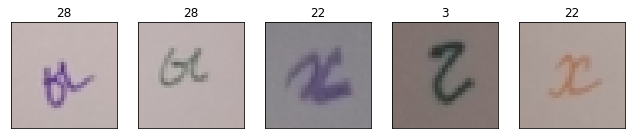

In [9]:
display_examples(valid_loader2,img_size)

## NNinNN

In [10]:
def convrelu(x,y,k,s,p):
    return tnn.Sequential(
        tnn.Conv2d(x,y,kernel_size=k,
                   stride=s,padding=p),\
        tnn.ReLU(inplace=True))
class NNinNN(tnn.Module):
    def __init__(self,num_classes):
        super(NNinNN,self).__init__()
        self.num_classes=num_classes
        self.classifier=tnn.Sequential(
            convrelu(3,192,5,1,2),
            convrelu(192,160,1,1,0),
            convrelu(160,96,1,1,0),
            tnn.MaxPool2d(kernel_size=3,
                          stride=2,padding=1),
            tnn.Dropout(.5),
            convrelu(96,192,5,1,2),
            convrelu(192,192,1,1,0),
            convrelu(192,192,1,1,0),
            tnn.AvgPool2d(kernel_size=3,
                          stride=2,padding=1),
            tnn.Dropout(.5),
            convrelu(192,192,3,1,1),
            convrelu(192,192,1,1,0),
            convrelu(192,self.num_classes,1,1,0),
            tnn.AvgPool2d(kernel_size=8,
                          stride=1,padding=0))
    def forward(self,x):
        x=self.classifier(x)
        logits=x.view(x.size(0),self.num_classes)
        probs=torch.softmax(logits,dim=1)
        return logits,probs

## Training

In [11]:
@register_line_magic
def train_run(epochs):
    epochs=int(epochs)
    for epoch in range(epochs):
        model.train()
        for batch_ids,(features,targets) in enumerate(train_loader):        
            features=features.to(dev); targets=targets.to(dev)
            logits,probs=model(features)
            cost=tnn.functional.cross_entropy(logits,targets)
            optimizer.zero_grad(); cost.backward()
            optimizer.step()
            if not batch_ids%100:
                print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                       %(epoch+1,epochs,batch_ids, 
                         len(train)//batch_size,cost))
        model.eval()
        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d train acc: %.2f%% valid acc: %.2f%%'%\
                  (epoch+1,epochs,
                   model_acc(model,train_loader),
                   model_acc(model,valid_loader)))

In [12]:
torch.manual_seed(random_seed)
num_classes=10; learning_rate=.0001
model=NNinNN(num_classes); model.to(dev)
optimizer=torch.optim.Adam(model.parameters(),
                           lr=learning_rate)

In [13]:
%train_run 200

Epoch: 001/200 | Batch 000/343 | Cost: 2.3027
Epoch: 001/200 | Batch 100/343 | Cost: 2.2053
Epoch: 001/200 | Batch 200/343 | Cost: 2.0365
Epoch: 001/200 | Batch 300/343 | Cost: 1.9258
Epoch: 001/200 train acc: 28.93% valid acc: 30.20%
Epoch: 002/200 | Batch 000/343 | Cost: 1.8936
Epoch: 002/200 | Batch 100/343 | Cost: 1.7738
Epoch: 002/200 | Batch 200/343 | Cost: 1.7650
Epoch: 002/200 | Batch 300/343 | Cost: 1.8411
Epoch: 002/200 train acc: 33.26% valid acc: 33.77%
Epoch: 003/200 | Batch 000/343 | Cost: 1.8382
Epoch: 003/200 | Batch 100/343 | Cost: 1.8759
Epoch: 003/200 | Batch 200/343 | Cost: 1.7575
Epoch: 003/200 | Batch 300/343 | Cost: 1.6379
Epoch: 003/200 train acc: 36.41% valid acc: 36.85%
Epoch: 004/200 | Batch 000/343 | Cost: 1.7890
Epoch: 004/200 | Batch 100/343 | Cost: 1.8864
Epoch: 004/200 | Batch 200/343 | Cost: 1.6317
Epoch: 004/200 | Batch 300/343 | Cost: 1.7834
Epoch: 004/200 train acc: 38.26% valid acc: 38.70%
Epoch: 005/200 | Batch 000/343 | Cost: 1.7018
Epoch: 005/200

In [14]:
%print_acc 1

Train accuracy: 83.9659%
Valid accuracy: 72.3500%
Test accuracy: 71.3900%


In [15]:
@register_line_magic
def train_run2(epochs):
    epochs=int(epochs)
    for epoch in range(epochs):
        model.train()
        for batch_ids,(features,targets) in enumerate(train_loader2):        
            features=features.to(dev); targets=targets.to(dev)
            logits,probs=model(features)
            cost=tnn.functional.cross_entropy(logits,targets.long())
            optimizer2.zero_grad(); cost.backward()
            optimizer2.step()
            if not batch_ids%50:
                print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                       %(epoch+1,epochs,batch_ids, 
                         len(train2)//batch_size2,cost))
        model.eval()         
        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d train acc: %.2f%% valid acc: %.2f%%'%\
                  (epoch+1,epochs,
                   model_acc(model,train_loader2),
                   model_acc(model,valid_loader2)))

In [16]:
torch.manual_seed(random_seed)
num_classes=33; learning_rate=.0001
model=NNinNN(num_classes)
model.to(dev)
optimizer2=torch.optim.Adam(model.parameters(),
                            lr=learning_rate)

In [17]:
%train_run2 300

Epoch: 001/300 | Batch 000/088 | Cost: 3.4943
Epoch: 001/300 | Batch 050/088 | Cost: 3.5005
Epoch: 001/300 train acc: 3.26% valid acc: 2.89%
Epoch: 002/300 | Batch 000/088 | Cost: 3.4982
Epoch: 002/300 | Batch 050/088 | Cost: 3.5023
Epoch: 002/300 train acc: 4.34% valid acc: 4.44%
Epoch: 003/300 | Batch 000/088 | Cost: 3.4789
Epoch: 003/300 | Batch 050/088 | Cost: 3.4562
Epoch: 003/300 train acc: 5.43% valid acc: 5.92%
Epoch: 004/300 | Batch 000/088 | Cost: 3.4552
Epoch: 004/300 | Batch 050/088 | Cost: 3.4327
Epoch: 004/300 train acc: 4.98% valid acc: 5.36%
Epoch: 005/300 | Batch 000/088 | Cost: 3.4388
Epoch: 005/300 | Batch 050/088 | Cost: 3.4359
Epoch: 005/300 train acc: 6.55% valid acc: 6.77%
Epoch: 006/300 | Batch 000/088 | Cost: 3.3594
Epoch: 006/300 | Batch 050/088 | Cost: 3.4375
Epoch: 006/300 train acc: 6.28% valid acc: 7.19%
Epoch: 007/300 | Batch 000/088 | Cost: 3.4197
Epoch: 007/300 | Batch 050/088 | Cost: 3.3580
Epoch: 007/300 train acc: 6.38% valid acc: 6.34%
Epoch: 008/30

In [18]:
%print_acc 2

Train accuracy: 74.0486%
Valid accuracy: 65.3277%
Test accuracy: 65.6801%
